In [23]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

import warnings
warnings.filterwarnings('ignore')

fontsize = 14
params = {'axes.labelsize': fontsize,
          'font.size': fontsize,
          'legend.fontsize': fontsize,
          'xtick.labelsize': fontsize,
          'ytick.labelsize': fontsize,
          'figure.figsize': (15, 10)}
plt.rcParams.update(params)

In [24]:
root_path = os.path.join('..', '..', 'cleaned_logs_to_keep', 'databricks', 'Python')
filenames = ['min_vs_distinct_edges_per_node.csv']

In [25]:
comparison_list = []

for filename in filenames:
    comparison = pd.read_csv(os.path.join(root_path, filename))
    comparison['end_of_command'] = pd.to_datetime(comparison['end_of_command'])
    comparison['duration'] = comparison['end_of_command'].diff().dt.total_seconds()
    comparison['edge_per_node'] = comparison['filename'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))
    comparison['duration'].fillna(0, inplace=True)
    comparison_list.append(comparison)
    
comparison_average = comparison_list[0].copy()
# comparison_average['duration'] = (comparison_average['duration'] + comparison_list[1]['duration']) / 2

In [26]:
distinct_df = comparison_average[comparison_average['algo_type'] == 'distinct']
min_df = comparison_average[comparison_average['algo_type'] == 'min']
three_edges = comparison_average[comparison_average['edge_per_node'] == 3]
seven_edges = comparison_average[comparison_average['edge_per_node'] == 7]
eleven_edges = comparison_average[comparison_average['edge_per_node'] == 11]

In [27]:
eleven_edges

,filename,algo_type,loop_counter,command,end_of_command,accum,duration,edge_per_node
30,dbfs:/FileStore/graph_10M_11.txt,distinct,0,start,2021-03-24 12:56:05.129764,0,2.644894,11
31,dbfs:/FileStore/graph_10M_11.txt,distinct,1,ded_reduce,2021-03-24 12:56:32.129095,1632643,26.999331,11
32,dbfs:/FileStore/graph_10M_11.txt,distinct,2,ded_reduce,2021-03-24 12:57:13.560904,3251069,41.431809,11
33,dbfs:/FileStore/graph_10M_11.txt,distinct,3,ded_reduce,2021-03-24 12:57:40.456821,5402843,26.895917,11
34,dbfs:/FileStore/graph_10M_11.txt,distinct,4,ded_reduce,2021-03-24 12:57:45.263538,297972,4.806717,11
35,dbfs:/FileStore/graph_10M_11.txt,distinct,5,ded_reduce,2021-03-24 12:57:48.244719,0,2.981181,11
36,dbfs:/FileStore/graph_10M_11.txt,min,0,start,2021-03-24 12:57:48.274681,0,0.029962,11
37,dbfs:/FileStore/graph_10M_11.txt,min,1,ded_reduce,2021-03-24 12:58:24.018457,1632643,35.743776,11
38,dbfs:/FileStore/graph_10M_11.txt,min,2,ded_reduce,2021-03-24 12:59:26.989206,3251069,62.970749,11
39,dbfs:/FileStore/graph_10M_11.txt,min,3,ded_reduce,2021-03-24 13:00:10.235793,5402843,43.246587,11


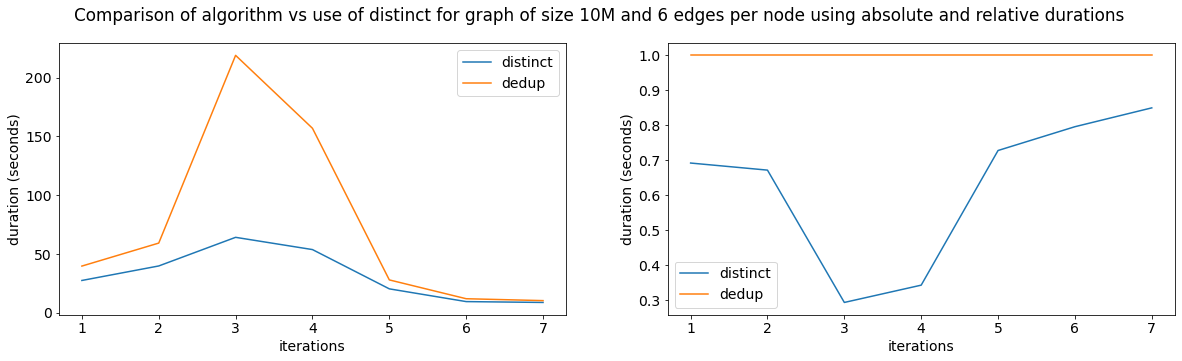

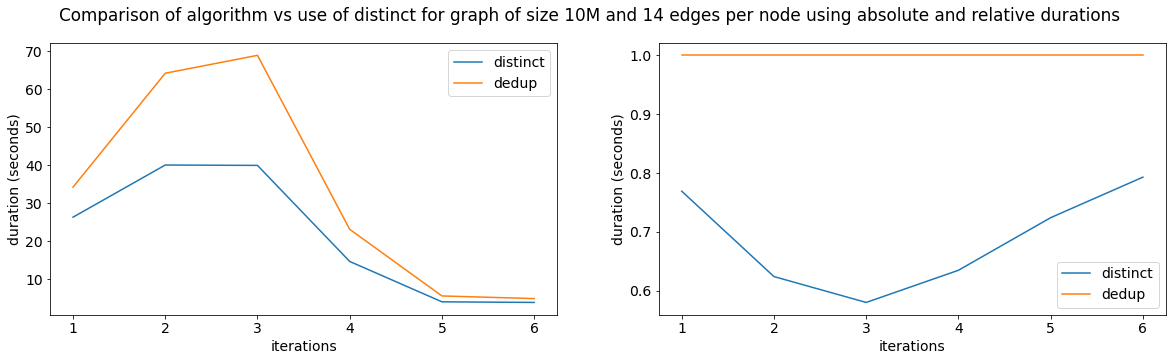

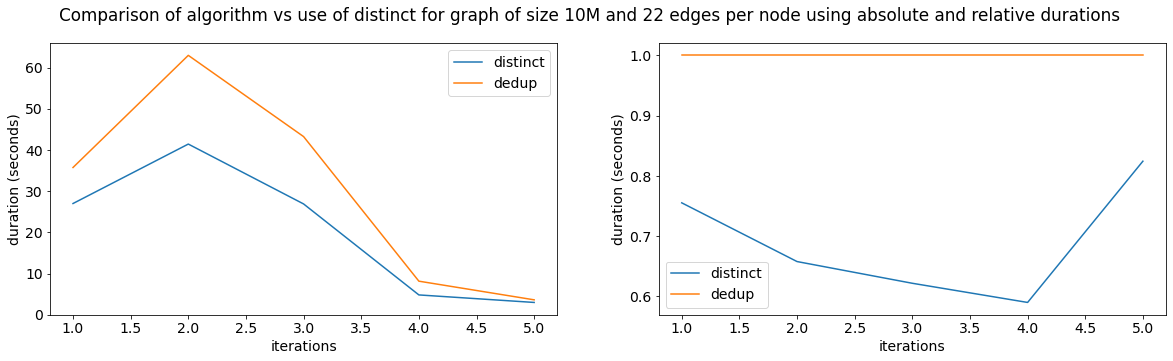

In [46]:
def plot_min_vs_distinct(df, title_arg):
    
    distinct_df = df[df['algo_type'] == 'distinct']
    min_df = df[df['algo_type'] == 'min']
    
    distinct_df.set_index('loop_counter', inplace=True)
    min_df.set_index('loop_counter', inplace=True)

    try:
        distinct_df.drop([0], inplace=True)
        min_df.drop([0], inplace=True)
    except:
        pass
    
    distinct_rel = distinct_df.copy()
    min_rel = min_df.copy()
    for i in range(len(distinct_rel)):
        distinct_rel.loc[i + 1, 'duration'] /= min_rel.loc[i + 1, 'duration']
        min_rel.loc[i + 1, 'duration'] = 1
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    abs_val_plt = ax[0]
    abs_val_plt.plot(distinct_df.index.values.astype(int), distinct_df['duration'], label='distinct')
    abs_val_plt.plot(min_df.index.values.astype(int), min_df['duration'], label='dedup')
    abs_val_plt.set_xlabel('iterations')
    abs_val_plt.set_ylabel('duration (seconds)')
    abs_val_plt.legend()
    
    rel_val_plt = ax[1]
    rel_val_plt.plot(distinct_rel.index.values.astype(int), distinct_rel['duration'], label='distinct')
    rel_val_plt.plot(min_rel.index.values.astype(int), min_rel['duration'], label='dedup')
    rel_val_plt.set_xlabel('iterations')
    rel_val_plt.set_ylabel('duration (seconds)')
    rel_val_plt.legend()
    
    fig.suptitle(f"Comparison of algorithm vs use of distinct for graph of size 10M and {str(title_arg)} edges per node using absolute and relative durations")
    
plot_min_vs_distinct(three_edges, 6)
plot_min_vs_distinct(seven_edges, 14)
plot_min_vs_distinct(eleven_edges, 22)

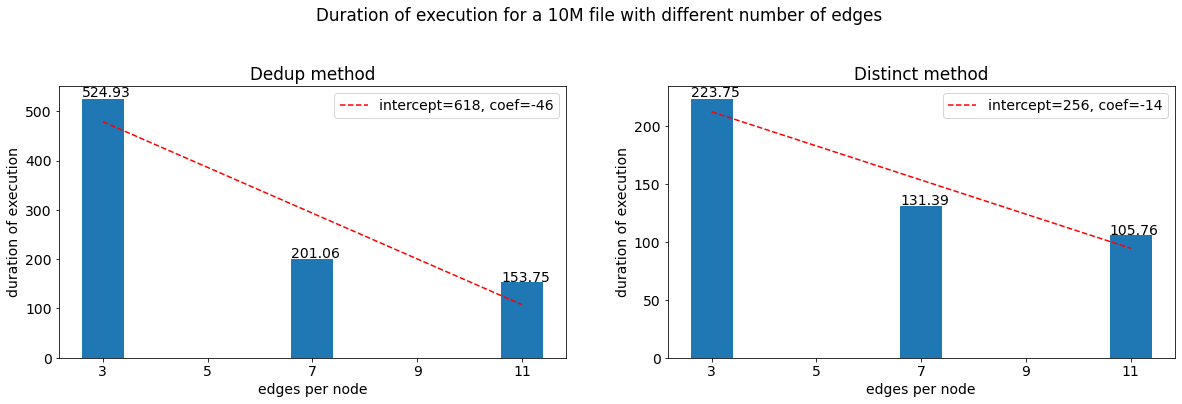

In [95]:
def plot_total_duration(group_by_edge_min, group_by_edge_distinct, title):
    
    def subplot_total_duration(group_by_edge_min, ax, subtitle):
        
        lin_reg = LinearRegression()
        lin_reg.fit(group_by_edge_min.T.columns.to_numpy().reshape(-1, 1), group_by_edge_min.T.loc['duration'])
        x = np.arange(min(group_by_edge_min.T.columns), max(group_by_edge_min.T.columns) + 1)
        y = x * lin_reg.coef_ + lin_reg.intercept_

        ax.bar(group_by_edge_min.T.columns, height=group_by_edge_min.T.loc['duration'])
        ax.set_xlabel('edges per node')
        ax.set_ylabel('duration of execution')
        ax.set_title(subtitle)
        ax.plot(x, y, 'r--', label=f"intercept={int(lin_reg.intercept_)}, coef={int(lin_reg.coef_)}")
        ax.set_xticks(np.arange(min(group_by_edge_min.T.columns), max(group_by_edge_min.T.columns) + 1, 2.0))
        ax.legend()

        for p in ax.patches:
            ax.annotate(str(round(p.get_height(), 2)), (p.get_x(), p.get_height() * 1.01))

    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    subplot_total_duration(group_by_edge_min, ax[0], 'Dedup method')
    subplot_total_duration(group_by_edge_distinct, ax[1], 'Distinct method')
    fig.suptitle(title, y=1.1)
    plt.show()
    

group_by_edge_min = min_df.groupby(['edge_per_node']).sum()
group_by_edge_distinct = distinct_df.groupby(['edge_per_node']).sum()
plot_total_duration(group_by_edge_min, group_by_edge_distinct, 'Duration of execution for a 10M file with different number of edges')

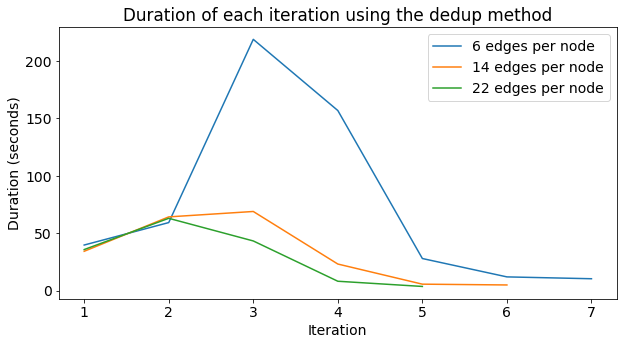

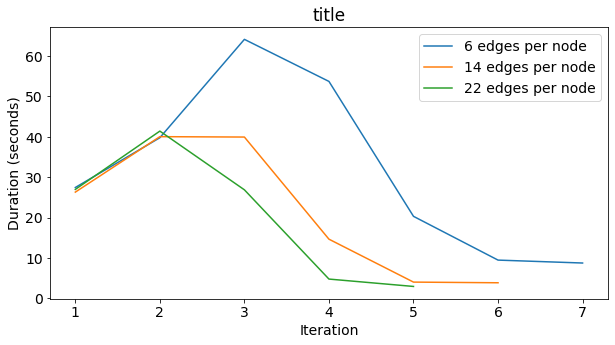

In [112]:
def plot_duration_edges_per_nodes(df, title):
    
    three_edges = df[df['edge_per_node'] == 3]
    seven_edges = df[df['edge_per_node'] == 7]
    eleven_edges = df[df['edge_per_node'] == 11]
    
    three_edges.set_index('loop_counter', inplace=True)
    seven_edges.set_index('loop_counter', inplace=True)
    eleven_edges.set_index('loop_counter', inplace=True)
    try:
        three_edges.drop([0], inplace=True)
        seven_edges.drop([0], inplace=True)
        eleven_edges.drop([0], inplace=True)
    except:
        pass
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
#     duration_plt = ax[0]
    ax.plot(three_edges['duration'], label='6 edges per node')
    ax.plot(seven_edges['duration'], label='14 edges per node')
    ax.plot(eleven_edges['duration'], label='22 edges per node')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Duration (seconds)")
    ax.set_title(title)
    ax.legend()
    
#     accum_plt = ax[1]
#     accum_plt.plot(three_edges['accum'], label='6 edges per node')
#     accum_plt.plot(seven_edges['accum'], label='14 edges per node')
#     accum_plt.plot(eleven_edges['accum'], label='22 edges per node')
#     accum_plt.legend()
    
    plt.show()
    
plot_duration_edges_per_nodes(min_df, 'Duration of each iteration using the dedup method')
plot_duration_edges_per_nodes(distinct_df, 'title')

In [133]:
def preprocess_logs(full_logs):
    
    full_logs['end_of_command'] = pd.to_datetime(full_logs['end_of_command'])
    full_logs['duration'] = full_logs['end_of_command'].diff().dt.total_seconds()
    full_logs['edge_per_node'] = full_logs['filename'].apply(lambda x: int(x.split('_')[-1].split('.')[0]))
    full_logs['duration'].fillna(0, inplace=True)
    
    return full_logs

full_logs = pd.read_csv(os.path.join(root_path, "min_vs_distinct_edges_per_node2.csv"))
full_logs = preprocess_logs(full_logs)

full_logs_min = full_logs[full_logs['algo_type'] == 'min']
full_logs_min_3 = full_logs_min[full_logs_min['edge_per_node'] == 3]
full_logs_min_3.reset_index(inplace=True)

In [65]:
full_logs_min_3

,index,filename,algo_type,loop_counter,command,end_of_command,accum,len_list,duration,edge_per_node
0,29,dbfs:/FileStore/graph_10M_3.txt,min,0,start,2021-03-24 15:15:45.179418,0,0,0.054813,3
1,30,dbfs:/FileStore/graph_10M_3.txt,min,1,it_map,2021-03-24 15:15:50.356214,0,1592880,5.176796,3
2,31,dbfs:/FileStore/graph_10M_3.txt,min,1,it_groupby,2021-03-24 15:16:02.697585,0,265570,12.341371,3
3,32,dbfs:/FileStore/graph_10M_3.txt,min,1,it_reduce,2021-03-24 15:16:09.063392,1149377,1371331,6.365807,3
4,33,dbfs:/FileStore/graph_10M_3.txt,min,1,ded_map,2021-03-24 15:16:16.831863,2298754,1371331,7.768471,3
5,34,dbfs:/FileStore/graph_10M_3.txt,min,1,ded_groupby,2021-03-24 15:16:52.833334,3448131,1371262,36.001471,3
6,35,dbfs:/FileStore/graph_10M_3.txt,min,1,ded_reduce,2021-03-24 15:17:02.336258,3448131,1371262,9.502924,3
7,36,dbfs:/FileStore/graph_10M_3.txt,min,2,it_map,2021-03-24 15:17:13.584941,0,2742524,11.248683,3
8,37,dbfs:/FileStore/graph_10M_3.txt,min,2,it_groupby,2021-03-24 15:17:31.833985,0,265570,18.249044,3
9,38,dbfs:/FileStore/graph_10M_3.txt,min,2,it_reduce,2021-03-24 15:17:39.022750,2226366,2484016,7.188765,3


In [71]:
def sort_commands(df):
    
    df['order'] = 0
    df.loc['it_map', 'order'] = 1
    df.loc['it_groupby', 'order'] = 2
    df.loc['it_reduce', 'order'] = 3
    df.loc['ded_map', 'order'] = 4
    df.loc['ded_groupby', 'order'] = 5
    df.loc['ded_reduce', 'order'] = 6
    df['command'] = df.index.values
    df.sort_values(by='order', inplace=True)
    df.set_index(['order'], inplace=True)
    return df

edges_3_cmd = full_logs_min_3.groupby(by=['command']).sum()
edges_3_cmd.drop(['start'], axis=0, inplace=True)
edges_3_cmd = sort_commands(edges_3_cmd)

In [74]:
durations = pd.DataFrame(edges_3_cmd[['command', 'duration']], index=edges_3_cmd.index)
durations.set_index('command', inplace=True)
durations

,duration
command,
it_map,157.314956
it_groupby,213.902555
it_reduce,51.418977
ded_map,76.104468
ded_groupby,411.015470
ded_reduce,142.582174


In [85]:
ded_group_by = full_logs_min_3[full_logs_min_3['command'] == 'ded_groupby']
ded_map = full_logs_min_3[full_logs_min_3['command'] == 'ded_map']

ded_group_by.reset_index(inplace=True)
ded_map.reset_index(inplace=True)

ded_map.rename({'len_list': 'len_input'}, inplace=True, axis=1)
ded_group_by = ded_group_by.merge(ded_map['len_input'], left_index=True, right_index=True)

In [97]:
ded_group_by

,level_0,index,filename,algo_type,loop_counter,command,end_of_command,accum,len_list,duration,edge_per_node,len_input
0,5,34,dbfs:/FileStore/graph_10M_3.txt,min,1,ded_groupby,2021-03-24 15:16:52.833334,3448131,1371262,36.001471,3,1371331
1,11,40,dbfs:/FileStore/graph_10M_3.txt,min,2,ded_groupby,2021-03-24 15:18:41.637341,6679098,2356984,52.674704,3,2484016
2,17,46,dbfs:/FileStore/graph_10M_3.txt,min,3,ded_groupby,2021-03-24 15:23:48.538141,13114716,4099099,226.616883,3,4636898
3,23,52,dbfs:/FileStore/graph_10M_3.txt,min,4,ded_groupby,2021-03-24 15:31:04.395758,23742696,1237332,58.097222,3,8179794
4,29,58,dbfs:/FileStore/graph_10M_3.txt,min,5,ded_groupby,2021-03-24 15:32:16.827078,5839887,269055,18.422732,3,2212192
5,35,64,dbfs:/FileStore/graph_10M_3.txt,min,6,ded_groupby,2021-03-24 15:32:47.730507,20952,265563,9.521523,3,272547
6,41,70,dbfs:/FileStore/graph_10M_3.txt,min,7,ded_groupby,2021-03-24 15:33:15.678893,0,265563,9.680935,3,265563


Text(0.5, 0.98, 'Duration of each groupby as a function of the sizes of its input and output')

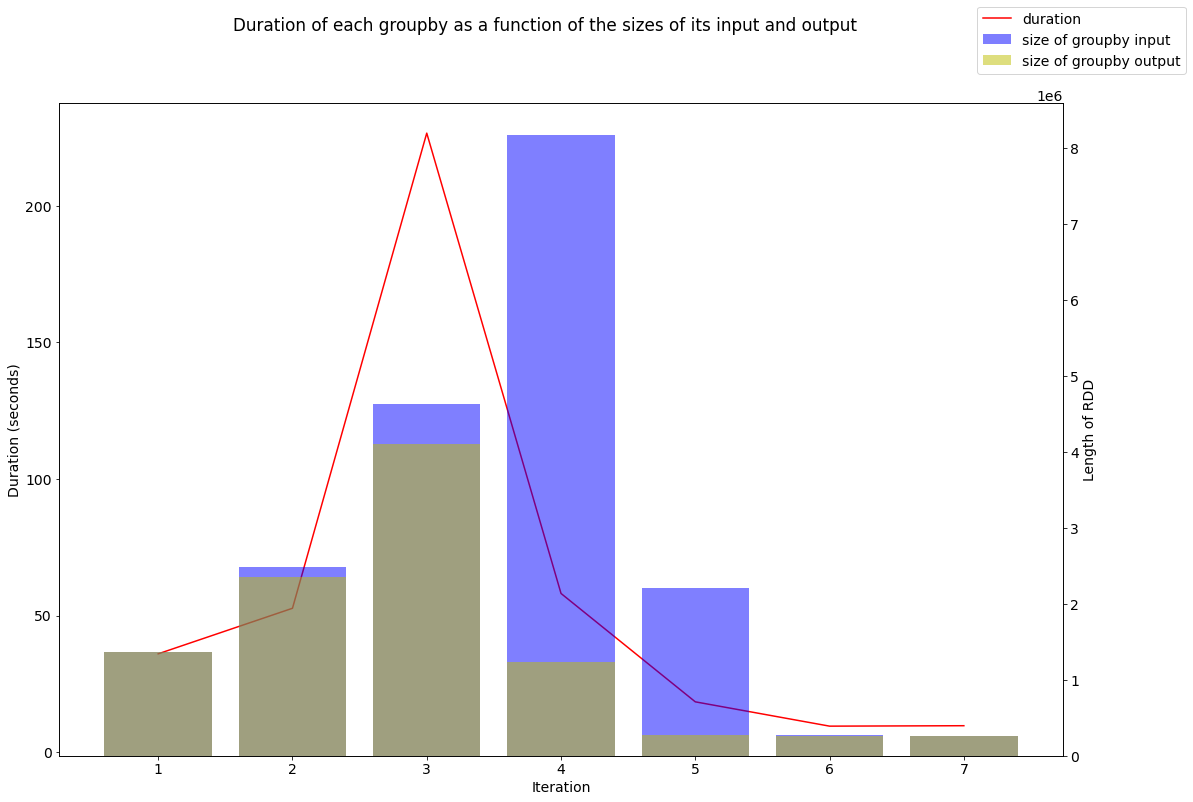

In [130]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(ded_group_by['loop_counter'], ded_group_by['duration'], color='r', label='duration')
ax.set_xlabel('Iteration')
ax.set_ylabel('Duration (seconds)')

ax2 = ax.twinx()
ax2.set_ylabel('Length of RDD')
ax2.bar(ded_group_by['loop_counter'], ded_group_by['len_input'], alpha=0.5, color='b', label='size of groupby input')
ax2.bar(ded_group_by['loop_counter'], ded_group_by['len_list'], alpha=0.5, color='y', label='size of groupby output')
fig.legend(loc='upper right')
fig.suptitle("Duration of each groupby as a function of the sizes of its input and output")

In [169]:
same_nodes = pd.read_csv(os.path.join(root_path, "same_nodes_full_logs.csv"))
same_nodes = preprocess_logs(same_nodes)
same_nodes

,filename,algo_type,loop_counter,command,end_of_command,accum,len_list,duration,edge_per_node
0,dbfs:/FileStore/graph_4M_3.txt,min,0,start,2021-03-24 18:26:08.094499,0,0,0.000000,3
1,dbfs:/FileStore/graph_4M_3.txt,min,1,it_map,2021-03-24 18:26:15.126310,0,694760,7.031811,3
2,dbfs:/FileStore/graph_4M_3.txt,min,1,it_groupby,2021-03-24 18:26:21.781501,0,115146,6.655191,3
3,dbfs:/FileStore/graph_4M_3.txt,min,1,it_reduce,2021-03-24 18:26:24.628048,502697,599047,2.846547,3
4,dbfs:/FileStore/graph_4M_3.txt,min,1,ded_map,2021-03-24 18:26:27.889579,1005394,599047,3.261531,3
...,...,...,...,...,...,...,...,...,...
106,dbfs:/FileStore/graph_15M_11.txt,min,5,it_groupby,2021-03-24 18:51:31.883774,0,117710,2.508206,11
107,dbfs:/FileStore/graph_15M_11.txt,min,5,it_reduce,2021-03-24 18:51:33.895006,0,117709,2.011232,11
108,dbfs:/FileStore/graph_15M_11.txt,min,5,ded_map,2021-03-24 18:51:36.431488,0,117709,2.536482,11
109,dbfs:/FileStore/graph_15M_11.txt,min,5,ded_groupby,2021-03-24 18:51:40.558053,0,117709,4.126565,11


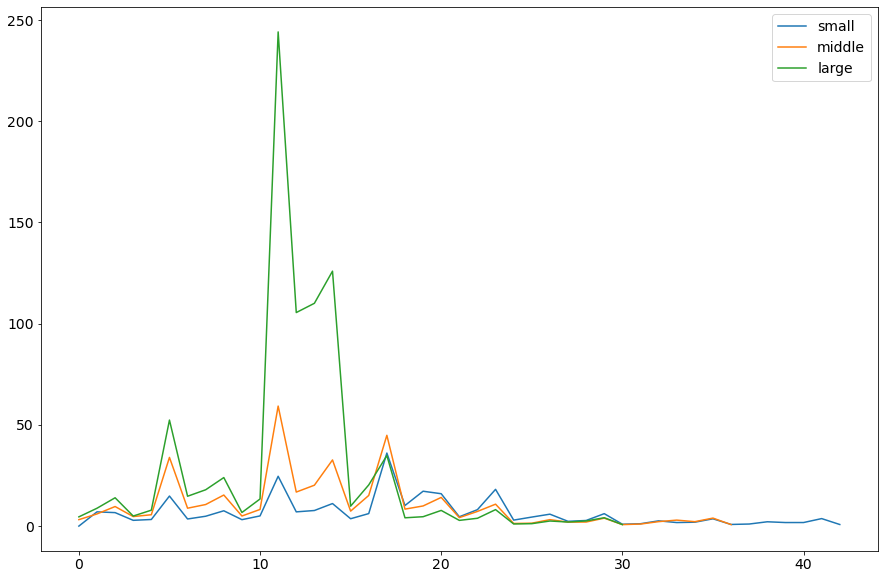

In [170]:
small_df = same_nodes[same_nodes['edge_per_node'] == 3]
mid_df = same_nodes[same_nodes['edge_per_node'] == 7]
big_df = same_nodes[same_nodes['edge_per_node'] == 11]

small_df.reset_index(inplace=True)
mid_df.reset_index(inplace=True)
big_df.reset_index(inplace=True)

plt.plot(small_df['duration'], label='small')
plt.plot(mid_df['duration'], label='middle')
plt.plot(big_df['duration'], label='large')

plt.legend()

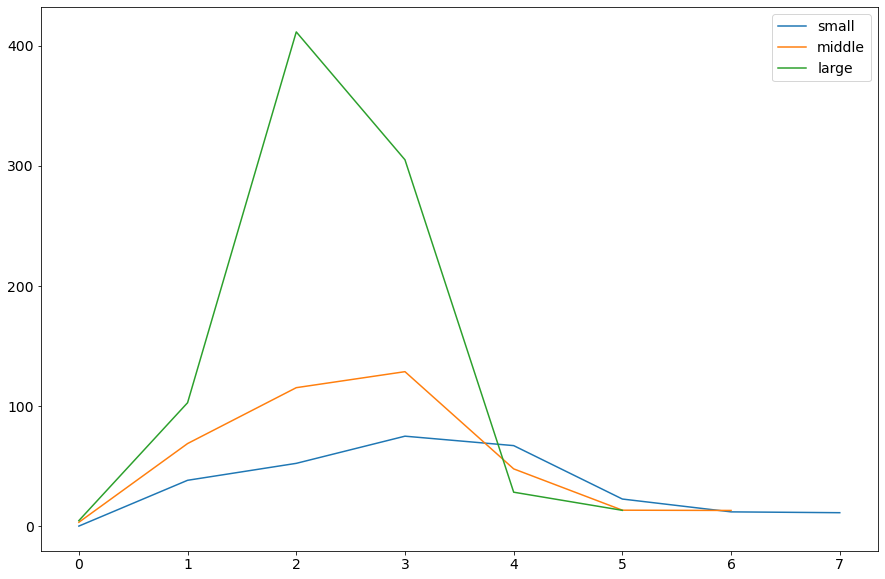

In [172]:
small_iter = small_df.groupby(by='loop_counter').sum()
mid_iter = mid_df.groupby(by='loop_counter').sum()
big_iter = big_df.groupby(by='loop_counter').sum()

plt.plot(small_iter['duration'], label='small')
plt.plot(mid_iter['duration'], label='middle')
plt.plot(big_iter['duration'], label='large')

plt.legend()

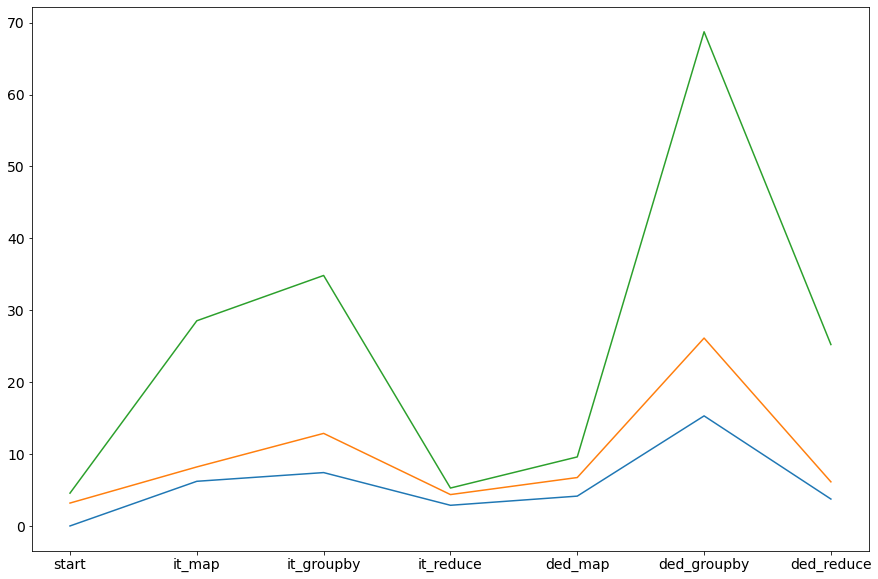

In [188]:
small_df_step = small_df.groupby(by='command').mean()
mid_df_step = mid_df.groupby(by='command').mean()
big_df_step = big_df.groupby(by='command').mean()

small_df_step = sort_commands(small_df_step)
mid_df_step = sort_commands(mid_df_step)
big_df_step = sort_commands(big_df_step)

small_df_step.set_index('command', inplace=True)
mid_df_step.set_index('command', inplace=True)
big_df_step.set_index('command', inplace=True)

plt.plot(small_df_step['duration'])
plt.plot(mid_df_step['duration'])
plt.plot(big_df_step['duration'])

In [189]:
small_df_step

,index,loop_counter,accum,len_list,duration,edge_per_node
command,,,,,,
start,0.0,0.0,0.0,0.000000e+00,0.000000,3.0
it_map,19.0,4.0,0.0,1.208881e+06,6.209603,3.0
it_groupby,20.0,4.0,0.0,1.151460e+05,7.420858,3.0
it_reduce,21.0,4.0,1012858.0,1.124815e+06,2.873055,3.0
ded_map,22.0,4.0,2025716.0,1.124815e+06,4.148453,3.0
ded_groupby,23.0,4.0,3038574.0,5.712637e+05,15.305688,3.0
ded_reduce,24.0,4.0,3038574.0,5.712637e+05,3.741314,3.0


In [195]:
def merge_groupby(df, step='ded'):

    ded_group_by = df[df['command'] == step + '_groupby']
    ded_map = df[df['command'] == step + '_map']

    ded_group_by.reset_index(inplace=True)
    ded_map.reset_index(inplace=True)

    ded_map.rename({'len_list': 'len_input'}, inplace=True, axis=1)
    ded_group_by = ded_group_by.merge(ded_map['len_input'], left_index=True, right_index=True)
    
    return ded_group_by

ded_group_by_small_it = merge_groupby(small_df, step='it')
ded_group_by_mid_it = merge_groupby(mid_df, step='it')
ded_group_by_large_it = merge_groupby(big_df, step='it')

ded_group_by_small_ded = merge_groupby(small_df, step='ded')
ded_group_by_mid_ded = merge_groupby(mid_df, step='ded')
ded_group_by_large_ded = merge_groupby(big_df, step='ded')

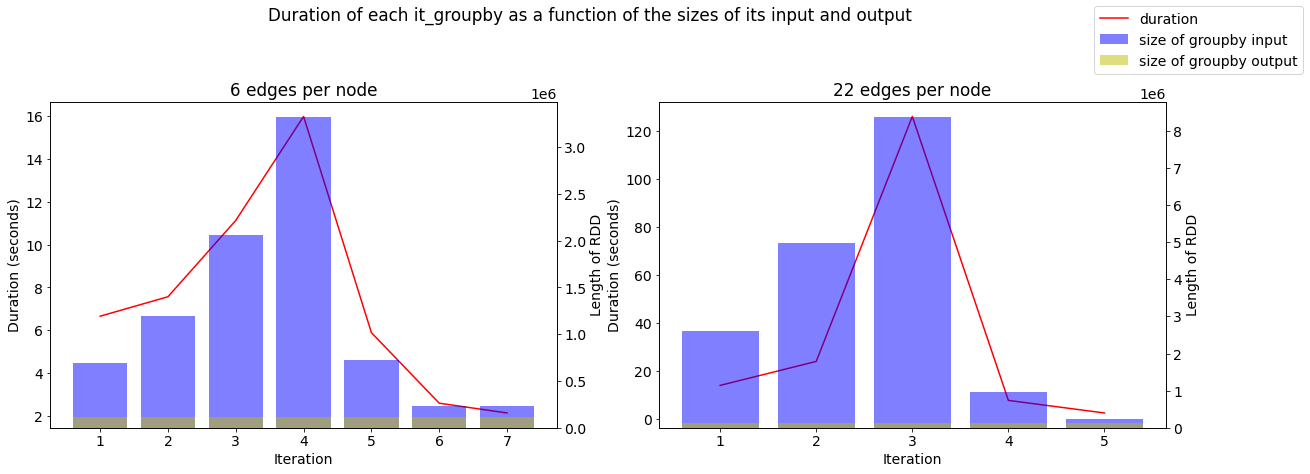

In [221]:
def plot_groupbys(ded_group_bys):

    def plot_groupby(ded_group_by, title, ax):
    
        ax.plot(ded_group_by['loop_counter'], ded_group_by['duration'], color='r', label='duration')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Duration (seconds)')

        ax2 = ax.twinx()
        ax2.set_ylabel('Length of RDD')
        ax2.bar(ded_group_by['loop_counter'], ded_group_by['len_input'], alpha=0.5, color='b', label='size of groupby input')
        ax2.bar(ded_group_by['loop_counter'], ded_group_by['len_list'], alpha=0.5, color='y', label='size of groupby output')
        ax.title.set_text(title)
        return ax2
    
    fig, ax = plt.subplots(nrows=1, ncols=len(ded_group_bys), figsize=(20, 6))
    titles = ["6 edges per node", "22 edges per node"]
    for i, ded_group_by in enumerate(ded_group_bys):
        ax2 = plot_groupby(ded_group_by, titles[i], ax[i]) 
    
    handles, labels = ax[0].get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles.extend(handles2)
    labels.extend(labels2)
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys())

    fig.suptitle("Duration of each it_groupby as a function of the sizes of its input and output", y=1.1)
    plt.show()
    
plot_groupbys([ded_group_by_small_it, ded_group_by_large_it])

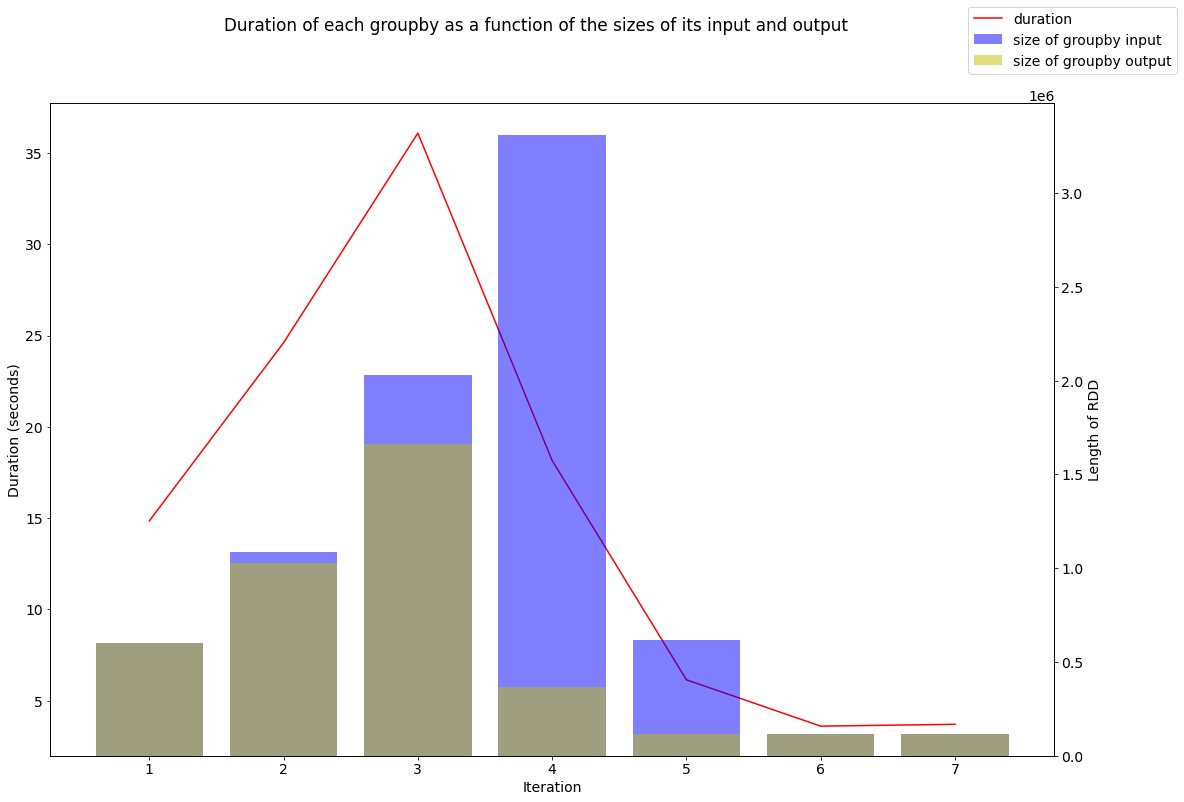

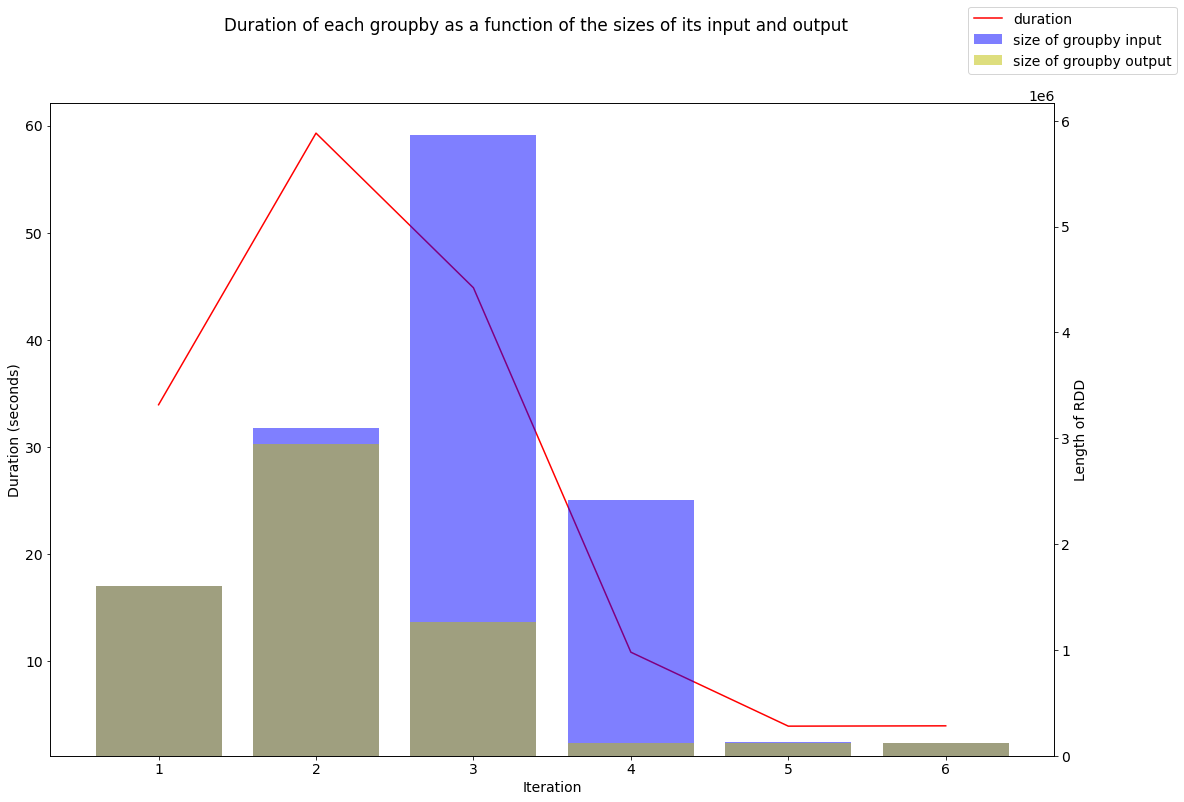

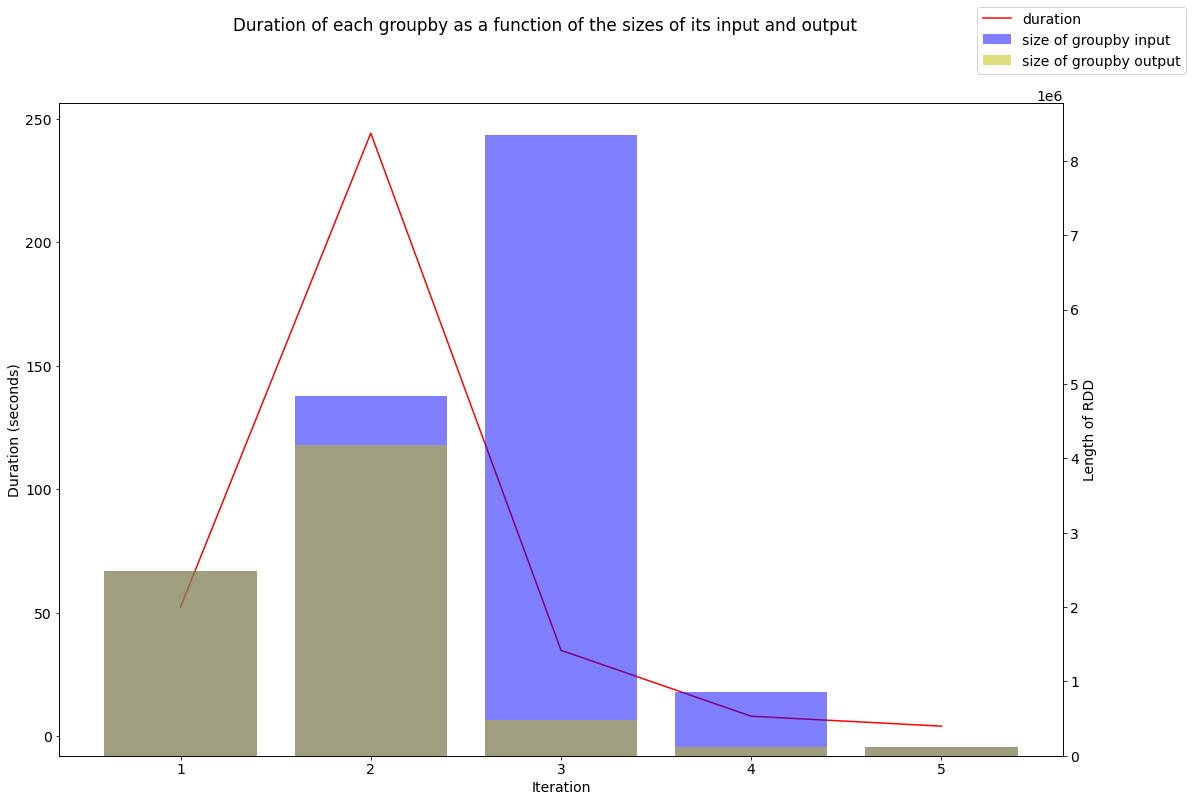

In [197]:
plot_groupby(ded_group_by_small_ded)
plot_groupby(ded_group_by_mid_ded)
plot_groupby(ded_group_by_large_ded)